#### Import necessary libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import yfinance

import matplotlib.pyplot as plt
from IPython.display import clear_output

#### Define what processor is available


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Download dataset


C:\Users\kent\AppData\Local\Temp\ipykernel_11268\2870745887.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yfinance.download("MSFT", "2000-01-01")
[*********************100%***********************]  1 of 1 completed


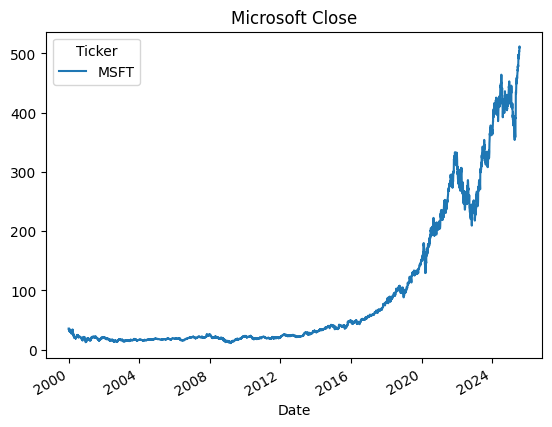

In [3]:
msft = yfinance.download("MSFT", "2000-01-01")
msft["Close"].plot(title="Microsoft Close")
plt.show()

In [4]:
dataset = msft["Close"].to_numpy()
dataset

array([[ 35.7267189 ],
       [ 34.51986694],
       [ 34.88383865],
       ...,
       [505.61999512],
       [511.70001221],
       [510.04998779]], shape=(6424, 1))

#### Setup Training and Test Data


In [5]:
training_size = int(0.8 * len(dataset))

X_train = torch.tensor(dataset[:training_size], dtype=torch.float32).to(device=device)
X_test = torch.tensor(dataset[training_size:], dtype=torch.float32).to(device=device)

X_train.size(), X_test.size()

(torch.Size([5139, 1]), torch.Size([1285, 1]))

#### Utility functions


Inverse function of standardization (z-score)


In [6]:
def denormalize_target_tensors(data: torch.Tensor, windows_stat: list[tuple]):
    return torch.stack(
        [(data[i] * std) + mean for i, (mean, std) in enumerate(windows_stat)]
    )

Sequential data generator function with per window normalization using z-score


In [7]:
def create_seq_data(
    data: torch.Tensor,
    seq_len: int,
    normalized: bool = False,
):
    windows_stat: list[tuple] = list()
    data_temp = list()
    for i in range(len(data) - seq_len):
        w_i = data[i : i + seq_len]
        if normalized:
            mean = w_i.mean()
            std = w_i.std()
            w_i = (w_i - mean) / std
            windows_stat.append((mean, std))
        data_temp.append(w_i)

    x = torch.stack(data_temp)[:, :-1, :]
    y = torch.stack(data_temp)[:, -1, :]

    return ((x, y), windows_stat)


#### Hyperparameters


In [8]:
time_length = 300
sequence_length = 30
batch_size = 8

epoch = 10

In [9]:
(X_train, Y_train), train_windows_stat = create_seq_data(
    data=X_train,
    seq_len=sequence_length,
    normalized=True,
)

(X_test, Y_test), test_windows_stat = create_seq_data(
    data=X_test,
    seq_len=sequence_length,
    normalized=True,
)

In [10]:
print("X_train size:", X_train.size(), Y_train.size())
print("X_test size:", X_test.size(), Y_test.size())

X_train size: torch.Size([5109, 29, 1]) torch.Size([5109, 1])
X_test size: torch.Size([1255, 29, 1]) torch.Size([1255, 1])


Batching function for dataset


In [11]:
def create_batched_dataset(dataset: torch.Tensor, batch_size):
    batched_dataset = list()
    for i in range(int(len(dataset) / batch_size)):
        batched_dataset.append(dataset[i : i + batch_size])
    return torch.stack(batched_dataset)


X_train_batched = create_batched_dataset(X_train, batch_size=batch_size)
Y_train_batched = create_batched_dataset(Y_train, batch_size=batch_size)

print("X_train batched size:", X_train_batched.size())
print("Y_train batched size:", Y_train_batched.size())

X_train batched size: torch.Size([638, 8, 29, 1])
Y_train batched size: torch.Size([638, 8, 1])


#### Define the model architecture


In [12]:
class StockMarketForecaster(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockMarketForecaster, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1,
        )
        self.fc1 = nn.Linear(in_features=hidden_size, out_features=int(hidden_size / 2))
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(self.fc1.out_features, int(self.fc1.out_features / 2))
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(self.fc2.out_features, out_features=output_size)

    def forward(self, x: torch.Tensor):
        out, h_n = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [13]:
model = StockMarketForecaster(input_size=1, hidden_size=32, num_layers=1, output_size=1)
model = model.to(device=device)

c:\Users\kent\Documents\Development\env-machine-learning\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


#### Loss and optimizer functions


In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### Visualize the source and test data


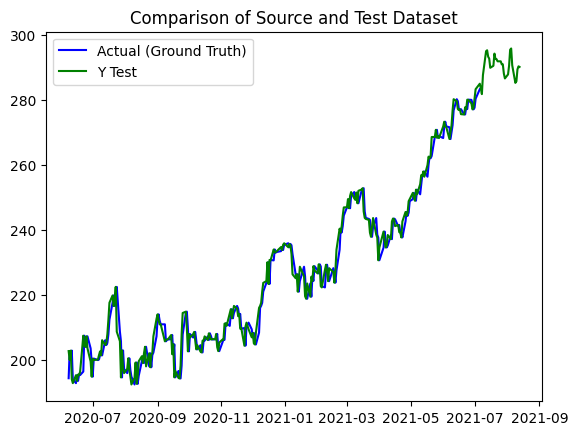

In [15]:
plt.plot(
    msft["Close"][training_size:-sequence_length].index[:time_length],
    msft["Close"][training_size:-sequence_length][:time_length].shift(-28),
    label="Actual (Ground Truth)",
    color="blue",
)

plt.plot(
    msft["Close"][training_size:-sequence_length].index[:time_length],
    denormalize_target_tensors(Y_test, test_windows_stat).cpu()[:time_length],
    label="Y Test",
    color="green",
)
plt.title("Comparison of Source and Test Dataset")
plt.legend()
plt.show()

#### Model training


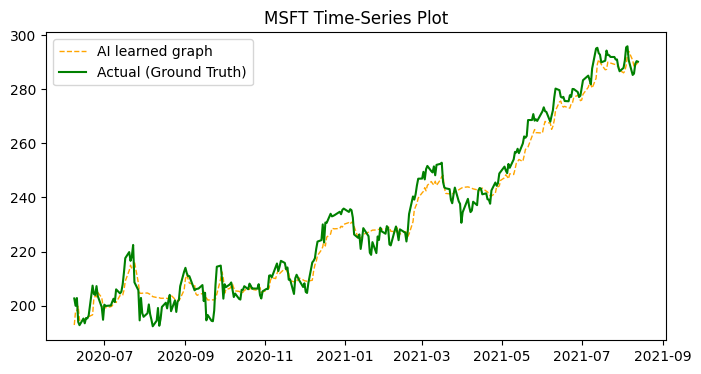

Epoch: 9 | Step: 601 | Loss: 0.6669312715530396


In [16]:
Y_test = denormalize_target_tensors(Y_test, test_windows_stat).cpu()
Y_test = Y_test[:time_length]
x_axis = msft["Close"][training_size:-sequence_length].index[:time_length]

for e in range(epoch):
    for i, (x, y) in enumerate(zip(X_train_batched, Y_train_batched)):
        model.train()
        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i % 100) == 0:
            plt.figure(figsize=(8, 4))
            model.eval()
            with torch.no_grad():
                y_pred_test = model(X_test)

                y_pred_test = (
                    denormalize_target_tensors(y_pred_test, test_windows_stat)
                    .detach()
                    .cpu()[:time_length]
                )

                plt.plot(
                    x_axis,
                    y_pred_test,
                    label="AI learned graph",
                    linestyle="--",
                    color="orange",
                    linewidth=1,
                )

                plt.plot(
                    x_axis,
                    Y_test,
                    label="Actual (Ground Truth)",
                    color="green",
                )

                plt.legend()
                plt.title("MSFT Time-Series Plot")

                clear_output(wait=True)
                plt.show()

                print(f"Epoch: {e} | Step: {i + 1} | Loss: {loss.item()}")